In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

In [2]:
# Convert class weights to tensor and move to the appropriate device (e.g., GPU if used)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [3]:
# Load embeddings and labels
train_embeddings = torch.load('train_embeddings.pt').to(device)
test_embeddings = torch.load('test_embeddings.pt').to(device)
val_embeddings = torch.load('val_embeddings.pt').to(device)

train_labels = torch.load('train_labels_tensor.pt').to(device)
test_labels = torch.load('test_labels_tensor.pt').to(device)
val_labels = torch.load('val_labels_tensor.pt').to(device)

In [4]:
import torch

# Assuming train_labels is a tensor with class indices
class_counts = torch.bincount(train_labels)  # Count occurrences of each class
total_samples = class_counts.sum()
class_distribution = class_counts.float() / total_samples * 100  # Percentage distribution

print(f'Class Distribution: {class_distribution.tolist()}%')


Class Distribution: [49.98383331298828, 50.016170501708984]%


In [5]:

# Assuming train_labels is a tensor with class indices
class_counts = torch.bincount(test_labels)  # Count occurrences of each class
total_samples = class_counts.sum()
class_distribution = class_counts.float() / total_samples * 100  # Percentage distribution

print(f'Class Distribution: {class_distribution.tolist()}%')

Class Distribution: [49.98490905761719, 50.01509094238281]%


In [6]:
train_embeddings.shape

torch.Size([185542, 775])

In [7]:
train_labels.shape

torch.Size([185542])

In [8]:
def normalize_embeddings(embeddings):
    norms = embeddings.norm(p=2, dim=1, keepdim=True)
    normalized_embeddings = embeddings / norms
    return normalized_embeddings

# Normalize the embeddings
train_combined_embeddings_tensor = normalize_embeddings(train_embeddings)
val_combined_embeddings_tensor = normalize_embeddings(val_embeddings)
test_combined_embeddings_tensor = normalize_embeddings(test_embeddings)

# Now the embeddings are normalized and ready for use
print("Train embeddings shape:", train_combined_embeddings_tensor.shape)
print("Validation embeddings shape:", val_combined_embeddings_tensor.shape)
print("Test embeddings shape:", test_combined_embeddings_tensor.shape)

Train embeddings shape: torch.Size([185542, 775])
Validation embeddings shape: torch.Size([23193, 775])
Test embeddings shape: torch.Size([23193, 775])


In [9]:
# Reshape the train embeddings

train_combined_embeddings_tensor = train_combined_embeddings_tensor.unsqueeze(1)  # Shape: [185659, 1, 775]

# Assuming val_combined_embeddings_tensor is your validation embeddings tensor
val_combined_embeddings_tensor = val_combined_embeddings_tensor.unsqueeze(1)  # Shape: [val_size, 1, 775]

# Assuming test_combined_embeddings_tensor is your test embeddings tensor
test_combined_embeddings_tensor = test_combined_embeddings_tensor.unsqueeze(1)  # Shape: [test_size, 1, 775]

In [10]:
batch_size=64
train_dataset = TensorDataset(train_combined_embeddings_tensor, train_labels)
val_dataset = TensorDataset(val_combined_embeddings_tensor, val_labels)
test_dataset = TensorDataset(test_combined_embeddings_tensor, test_labels)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [11]:
print(train_combined_embeddings_tensor.shape)
print(val_combined_embeddings_tensor.shape)
print(test_combined_embeddings_tensor.shape)

torch.Size([185542, 1, 775])
torch.Size([23193, 1, 775])
torch.Size([23193, 1, 775])


In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class EmbeddingCNN(nn.Module):
    def __init__(self, input_channels, seq_len):
        super(EmbeddingCNN, self).__init__()
        #self.conv1 = nn.Conv1d(in_channels=seq_len, out_channels=64, kernel_size=1)  # Kernel size of 1
        #self.bn1 = nn.BatchNorm1d(64)
        #self.pool = nn.MaxPool1d(kernel_size=1, stride=1)
        #self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)  # Kernel size of 1
        #self.bn2 = nn.BatchNorm1d(128)
        #self.fc1 = nn.Linear(128, 256)  # Adjust based on output size after conv and pool
        #self.fc2 = nn.Linear(256, 1)
        #self.sigmoid = nn.Sigmoid()
        self.conv1 = nn.Conv1d(in_channels=seq_len, out_channels=64, kernel_size=1)
        self.bn1 = nn.BatchNorm1d(64)
        self.pool1 = nn.MaxPool1d(kernel_size=1, stride=1)
        self.dropout1 = nn.Dropout(p=0.5)  # Dropout layer with 50% probability
        self.conv2 = nn.Conv1d(in_channels=64, out_channels=128, kernel_size=1)
        self.bn2 = nn.BatchNorm1d(128)
        self.pool2 = nn.MaxPool1d(kernel_size=1, stride=1)
        self.dropout2 = nn.Dropout(p=0.2)  # Dropout layer with 50% probability
        self.fc1 = nn.Linear(128 * 1, 256)  # Adjust based on input size
        self.dropout3 = nn.Dropout(p=0.5)  # Dropout layer with 50% probability
        self.fc2 = nn.Linear(256, 1)  # Output layer
        

    

    def forward(self, x):
        #print (f'input shape is {x.shape}')
        x = x.squeeze(1)  # Remove the channel dimension to (batch_size, seq_len, input_dim)
        x = F.relu(self.bn1(self.conv1(x)))
        #print(f'after convoltution 1  shape is {x.shape}')
        x = self.pool1(x)
        #print(f'after poolin shape is {x.shape}')
        x=self.dropout1(x)
        x = F.relu(self.bn2(self.conv2(x)))
        #print(f'after conv 2 shape is {x.shape}')
        x = self.pool2(x)
        #print(f'sfter pooling 2 shape is {x.shape}')
        x=self.dropout2(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        #print (f'after falttening the shape is {x.shape}')
        x = F.relu(self.fc1(x))
        #print (f'linaer layer 1{x.shape}')
        x=self.dropout3(x)
        
        x = self.fc2(x)
        #print(f'linear layer 2 shape is {x.shape}')
        
        return x




In [13]:
# Example usage:
input_channels = 1  # Your data has 1 channel
seq_len = 775        # Sequence length
model = EmbeddingCNN(input_channels, seq_len).to(device)
criterion = nn.BCEWithLogitsLoss()  # Binary Cross-Entropy Loss
#optimizer = torch.optim.Adam(model.parameters(), lr=1e-4 ,  weight_decay=1e-5)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [47]:
import numpy as np
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import torch
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Assume your data is stored in `all_embeddings` and `all_labels`
# Convert them to lists for easier handling with KFold
#all_embeddings = np.array(all_embeddings)
#all_labels = np.array(all_labels)

# Define the number of folds
num_folds = 5

# Initialize KFold
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold_results = []

for fold, (train_index, val_index) in enumerate(kf.split(train_embeddings)):
    print(f"Processing Fold {fold + 1}/{num_folds}")

    # Create train and validation datasets
    train_dataset = Subset(TensorDataset(train_embeddings, train_labels), train_index)
    val_dataset = Subset(TensorDataset(train_embeddings, train_labels), val_index)
    
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



    # Training loop
    num_epochs = 10
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        all_labels=[]
        all_preds=[]

        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.unsqueeze(2).to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), labels.float())
            
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * embeddings.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()

            #------------------------------------------------
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            #-----------------------------------------------------

            total_train += labels.size(0)
            correct_train += (predicted.squeeze() == labels).sum().item()

        train_loss = running_loss / len(train_loader.dataset)
        train_accuracy = 100.0 * correct_train / total_train
        train_precesion = precision_score(all_labels, all_preds)
        train_recall = recall_score(all_labels, all_preds)
        train_f1 = f1_score(all_labels, all_preds)

        # Validation loop
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        #------------
        all_preds = []
        all_labels = []

        with torch.no_grad():
            for embeddings, labels in val_loader:
                embeddings, labels = embeddings.unsqueeze(2).to(device), labels.to(device)
                
                outputs = model(embeddings)
                loss = criterion(outputs.squeeze(), labels.float())
                
                val_loss += loss.item() * embeddings.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()

                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                total_val += labels.size(0)
                correct_val += (predicted.squeeze() == labels).sum().item()

        val_loss /= len(val_loader.dataset)
        val_accuracy = 100.0 * correct_val / total_val

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print('---')

        # Calculate precision, recall, and F1 score
        val_precision = precision_score(all_labels, all_preds)
        val_recall = recall_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds)

        print(f'Epoch {epoch + 1}/{num_epochs}')
        print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
        print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        print(f'Validation Precision: {val_precision:.4f}, Recall: {val_recall:.4f}, F1 Score: {val_f1:.4f}')
        print('---')

    # Store results for this fold
    fold_results.append({
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'train_precesion':train_precesion,
        'train_recall':train_recall,
        'train_F1':train_f1,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy,
        'val_precesion' : val_precision,
        'val_recall':val_recall,
        'val_F1':val_f1
    })

# Aggregate and print results
avg_train_loss = np.mean([result['train_loss'] for result in fold_results])
avg_train_accuracy = np.mean([result['train_accuracy'] for result in fold_results])
avg_train_precesion=np.mean([result['train_precesion'] for result in fold_results])
avg_train_recall=np.mean([result['train_recall'] for result in fold_results])
avg_train_F1=np.mean([result['train_F1'] for result in fold_results])

avg_val_loss = np.mean([result['val_loss'] for result in fold_results])
avg_val_accuracy = np.mean([result['val_accuracy'] for result in fold_results])
avg_val_precesion=np.mean([result['val_precesion'] for result in fold_results])
avg_val_recall=np.mean([result['val_recall'] for result in fold_results])
avg_val_F1=np.mean([result['val_F1'] for result in fold_results])


print(f'Average Train Loss: {avg_train_loss:.4f}')
print(f'Average Train Accuracy: {avg_train_accuracy:.4f}%')
print (f'Average Train Precesion: {avg_train_precesion:.4f}%')
print (f'Average Train Recall: {avg_train_recall:.4f}%')
print (f'Average Train F1: {avg_train_F1:.4f}%')

print(f'Average Validation Loss: {avg_val_loss:.4f}')
print(f'Average Validation Accuracy: {avg_val_accuracy:.4f}%')
print (f'Average Validation Precesion: {avg_val_precesion:.4f}%')
print (f'Average Validation Recall: {avg_val_recall:.4f}%')
print (f'Average Validation F1: {avg_val_F1:.4f}%')




Processing Fold 1/5
Epoch 1/10
Train Loss: 0.1810, Train Accuracy: 93.23%
Validation Loss: 0.1997, Validation Accuracy: 93.25%
---
Epoch 1/10
Train Loss: 0.1810, Train Accuracy: 93.23%
Validation Loss: 0.1997, Validation Accuracy: 93.25%
Validation Precision: 0.9594, Recall: 0.9027, F1 Score: 0.9302
---
Epoch 2/10
Train Loss: 0.1803, Train Accuracy: 93.27%
Validation Loss: 0.2002, Validation Accuracy: 93.36%
---
Epoch 2/10
Train Loss: 0.1803, Train Accuracy: 93.27%
Validation Loss: 0.2002, Validation Accuracy: 93.36%
Validation Precision: 0.9588, Recall: 0.9057, F1 Score: 0.9315
---
Epoch 3/10
Train Loss: 0.1808, Train Accuracy: 93.26%
Validation Loss: 0.2174, Validation Accuracy: 92.36%
---
Epoch 3/10
Train Loss: 0.1808, Train Accuracy: 93.26%
Validation Loss: 0.2174, Validation Accuracy: 92.36%
Validation Precision: 0.9658, Recall: 0.8777, F1 Score: 0.9197
---
Epoch 4/10
Train Loss: 0.1800, Train Accuracy: 93.23%
Validation Loss: 0.2061, Validation Accuracy: 92.75%
---
Epoch 4/10
Tra

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

In [32]:
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [49]:
# Set the model to evaluation mode
model.eval()

# Initialize variables to track test loss and accuracy
test_loss = 0.0
correct = 0
total = 0

# Initialize lists to store true labels and predicted probabilities for ROC-AUC calculation
all_labels = []
all_probs = []

# Initialize variables to calculate precision, recall, and F1 score
true_positives = 0
false_positives = 0
false_negatives = 0
true_negatives = 0

# No need to track gradients during testing
with torch.no_grad():
    for embeddings, labels in test_loader:  # Assuming `test_loader` is your DataLoader for the test dataset
        embeddings, labels = embeddings.to(device), labels.to(device)        # If embeddings are of shape [batch_size, 775], reshape to [batch_size, 1, 775]
      
        #print (embeddings.shape)
        embeddings = embeddings.permute(0, 2, 1) 


        
        # Forward pass
        outputs = model(embeddings).squeeze()
        
        # Calculate loss
        loss = criterion(outputs, labels.float())
        test_loss += loss.item()
        
        # Convert outputs to binary predictions

        #_, predicted = torch.max(outputs, 1)
        predicted = ((torch.sigmoid(outputs)) > 0.50).float()
        #(outputs > 0.5 ).float()
        
        

        #After computing probabilities
        #print("Predicted probabilities:", torch.sigmoid(outputs).cpu().numpy())
        #print("True labels:", labels.cpu().numpy())

        #predicted = (outputs > 0.5).float()
        #print(predicted , labels)

        # Collect true labels and predicted probabilities
        all_labels.extend(labels.cpu().numpy())
        all_probs.extend(torch.sigmoid(outputs).cpu().numpy())
        
        # Count correct predictions
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

        # Calculate true positives, false positives, and false negatives
        true_positives += ((predicted == 1) & (labels == 1)).sum().item()
        false_positives += ((predicted == 1) & (labels == 0)).sum().item()
        false_negatives += ((predicted == 0) & (labels == 1)).sum().item()
        true_negatives += ((predicted == 0) & (labels == 0)).sum().item()

# Calculate average loss and accuracy
test_loss /= len(test_loader)
test_accuracy = correct / total


print (f'true positives : {true_positives} , true negatives : {true_negatives}')
# Calculate precision, recall, and F1 score
precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Precision: {precision:.4f}, Test Recall: {recall:.4f}, Test F1 Score: {f1_score:.4f}')

print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy * 100}%')


true positives : 11600 , true negatives : 0
Test Loss: 1.0404, Test Accuracy: 50.02%
Test Precision: 0.5002, Test Recall: 1.0000, Test F1 Score: 0.6668
Test Loss: 1.0403508360064062, Test Accuracy: 50.015090760143146%


----------CODE ENDS HERE--------------------------------

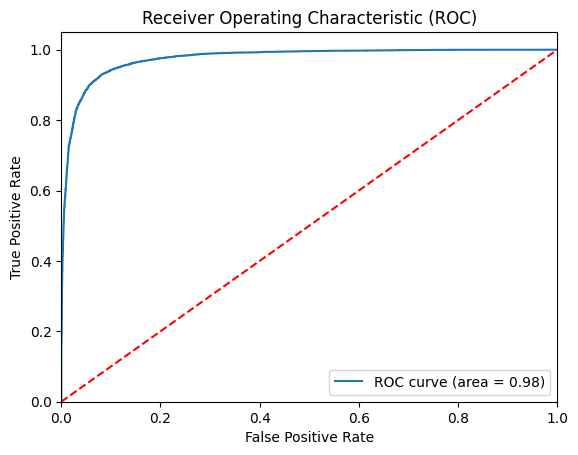

In [17]:
# Calculate ROC curve and AUC score
fpr, tpr, _ = roc_curve(all_labels, all_probs)
roc_auc = roc_auc_score(all_labels, all_probs)

# Plot ROC-AUC curve
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='r')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# older codes 

In [ ]:
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Assume model, criterion, optimizer, and data loaders are already defined
# model = CNNClassifier(input_dim=775).to(device)
# criterion = nn.BCEWithLogitsLoss()  # Using BCEWithLogitsLoss for binary classification
# optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Define data loaders (assuming you are using DataLoader)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

# Initialize lists to store metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
train_precisions, val_precisions = [], []
train_recalls, val_recalls = [], []
train_f1_scores, val_f1_scores = [], []

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    train_loss = 0.0
    correct_train = 0
    total_train = 0
    true_positives_train, false_positives_train, false_negatives_train = 0, 0, 0

    for embeddings, labels in train_loader:
        embeddings, labels = embeddings.unsqueeze(2).to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(embeddings)
        loss = criterion(outputs.squeeze(), labels.float())
        
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * embeddings.size(0)
        predicted = (torch.sigmoid(outputs) > 0.5).float()  # Thresholding
        total_train += labels.size(0)
        correct_train += (predicted.squeeze() == labels).sum().item()

        # Calculate true positives, false positives, and false negatives
        true_positives_train += ((predicted == 1) & (labels == 1)).sum().item()
        false_positives_train += ((predicted == 1) & (labels == 0)).sum().item()
        false_negatives_train += ((predicted == 0) & (labels == 1)).sum().item()

    # Calculate average training loss and accuracy
    train_loss /= len(train_loader.dataset)
    train_accuracy = 100.0 * correct_train / total_train

    # Calculate precision, recall, and F1 score for training
    train_precision = true_positives_train / (true_positives_train + false_positives_train) if (true_positives_train + false_positives_train) > 0 else 0
    train_recall = true_positives_train / (true_positives_train + false_negatives_train) if (true_positives_train + false_negatives_train) > 0 else 0
    train_f1_score = 2 * (train_precision * train_recall) / (train_precision + train_recall) if (train_precision + train_recall) > 0 else 0

    # Store training metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    train_precisions.append(train_precision)
    train_recalls.append(train_recall)
    train_f1_scores.append(train_f1_score)

    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    true_positives_val, false_positives_val, false_negatives_val = 0, 0, 0

    with torch.no_grad():
        for embeddings, labels in val_loader:
            embeddings, labels = embeddings.unsqueeze(2).to(device), labels.to(device)
            
            outputs = model(embeddings)
            loss = criterion(outputs.squeeze(), labels.float())
            
            val_loss += loss.item() * embeddings.size(0)
            predicted = (torch.sigmoid(outputs) > 0.5).float()  # Thresholding
            total_val += labels.size(0)
            correct_val += (predicted.squeeze() == labels).sum().item()

            # Calculate true positives, false positives, and false negatives
            true_positives_val += ((predicted == 1) & (labels == 1)).sum().item()
            false_positives_val += ((predicted == 1) & (labels == 0)).sum().item()
            false_negatives_val += ((predicted == 0) & (labels == 1)).sum().item()

    # Calculate average validation loss and accuracy
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100.0 * correct_val / total_val

    # Calculate precision, recall, and F1 score for validation
    val_precision = true_positives_val / (true_positives_val + false_positives_val) if (true_positives_val + false_positives_val) > 0 else 0
    val_recall = true_positives_val / (true_positives_val + false_negatives_val) if (true_positives_val + false_negatives_val) > 0 else 0
    val_f1_score = 2 * (val_precision * val_recall) / (val_precision + val_recall) if (val_precision + val_recall) > 0 else 0

    # Store validation metrics
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    val_precisions.append(val_precision)
    val_recalls.append(val_recall)
    val_f1_scores.append(val_f1_score)

    # Print statistics
    print(f'Epoch {epoch+1}/{num_epochs}')
    print(f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%')
    print(f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    print('---')

# Plotting
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(14, 8))

# Plot Loss
plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, 'b', label='Training Loss')
plt.plot(epochs, val_losses, 'r', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plot Accuracy
plt.subplot(2, 2, 2)
plt.plot(epochs, train_accuracies, 'b', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot Precision, Recall, and F1 Score
plt.subplot(2, 2, 3)
plt.plot(epochs, train_precisions, 'b', label='Training Precision')
plt.plot(epochs, val_precisions, 'r', label='Validation Precision')
plt.title('Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 4)
plt.plot(epochs, train_recalls, 'b', label='Training Recall')
plt.plot(epochs, val_recalls, 'r', label='Validation Recall')
plt.plot(epochs, train_f1_scores, 'g', label='Training F1 Score')
plt.plot(epochs, val_f1_scores, 'y', label='Validation F1 Score')
plt.title('Recall and F1 Score')
plt.xlabel('Epochs')
plt.ylabel('Score')
plt.legend()

plt.tight_layout()
plt.show()
